1 - Import Libraries

In [1]:
# Importing essential libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from random import randint
import warnings

In [2]:
nltk.download('stopwords')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Utkarsh
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2 - Load Database

In [3]:
# Loading the dataset
df = pd.read_csv('news-headlines.csv', index_col=["Date"], encoding='ISO-8859-1')
df.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar's debut double,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,Hopkins 'furious' at Foster's lack of Hannibal...,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,McGrath puts India out of their misery,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
2000-01-06,1,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,"Auntie back in fashion, even if the dress look...",Shoaib appeal goes to the top,Hussain hurt by 'shambles' but lays blame on e...,England's decade of disasters,...,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for...,Christmas glitches,"Upending a table, Chopping a line and Scoring ...","Scientific evidence 'unreliable', defence claims",Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake-up of failing NHS,Lessons of law's hard heart
2000-01-07,1,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers: are you all whingers?,Hollywood Beyond,Ashes and diamonds,Whingers - a formidable minority,Alan Parker - part two,...,Most everywhere: UDIs,Most wanted: Chloe lunettes,Return of the cane 'completely off the agenda',From Sleepy Hollow to Greeneland,Blunkett outlines vision for over 11s,"Embattled Dobson attacks 'play now, pay later'...",Doom and the Dome,What is the north-south divide?,Aitken released from jail,Gone aloft


In [4]:
df.columns

Index(['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8',
       'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16',
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25'],
      dtype='object')

In [5]:
df.shape

(4101, 26)

3 - Data Cleaning & Preprocessing

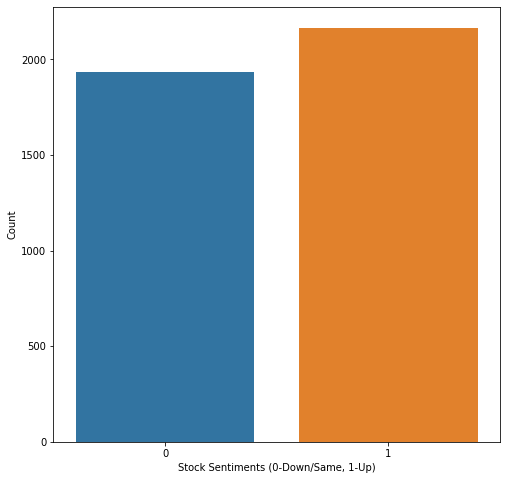

In [6]:
# Visualizing the count of 'Label' column from the dataset
%matplotlib inline
plt.figure(figsize=(8, 8))
sns.countplot(x='Label', data=df)
plt.xlabel('Stock Sentiments (0-Down/Same, 1-Up)')
plt.ylabel('Count')
plt.show()

In [7]:
df.isna().any()

Label    False
Top1     False
Top2     False
Top3     False
Top4     False
Top5     False
Top6     False
Top7     False
Top8     False
Top9     False
Top10    False
Top11    False
Top12    False
Top13    False
Top14    False
Top15    False
Top16    False
Top17    False
Top18    False
Top19    False
Top20    False
Top21    False
Top22    False
Top23     True
Top24     True
Top25     True
dtype: bool

In [8]:
# Dropping NaN values
df.dropna(inplace=True)
print(df.shape)

(4098, 26)


In [9]:
# Backup the database
df_backup = df.copy()
df.reset_index(inplace=True)

In [10]:
# Splitting the dataset into train an test set
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']
print('Train size: {}, Test size: {}'.format(train.shape, test.shape))

Train size: (3972, 27), Test size: (378, 27)


In [11]:
# Splitting the dataset
y_train = train['Label']
train = train.iloc[:, 3:28]
y_test = test['Label']
test = test.iloc[:, 3:28]

In [12]:
# Removing punctuation and special character from the text
train.replace(to_replace='[^a-zA-Z]', value=' ', regex=True, inplace=True)
test.replace(to_replace='[^a-zA-Z]', value=' ', regex=True, inplace=True)

In [13]:
# Renaming columns
new_columns = [str(i) for i in range(0, 24)]
train.columns = new_columns
test.columns = new_columns

In [14]:
# Converting the entire text to lower case
for i in new_columns:
    train[i] = train[i].str.lower()
    test[i] = test[i].str.lower()

In [15]:
# Joining all the columns
train_headlines = []
test_headlines = []

for row in range(0, train.shape[0]):
    train_headlines.append(' '.join(str(x) for x in train.iloc[row, 0:25]))

for row in range(0, test.shape[0]):
    test_headlines.append(' '.join(str(x) for x in test.iloc[row, 0:25]))

In [16]:
train_headlines[0]

'scorecard hughes  instant hit buoys blues jack gets his skates on at ice cold alex chaos as maracana builds up for united depleted leicester prevail as elliott spoils everton s party hungry spurs sense rich pickings gunners so wide of an easy target derby raise a glass to strupar s debut double southgate strikes  leeds pay the penalty hammers hand robson a youthful lesson saints party like it s      wear wolves have turned into lambs stump mike catches testy gough s taunt langer escapes to hit     flintoff injury piles on woe for england hunters threaten jospin with new battle of the somme kohl s successor drawn into scandal the difference between men and women sara denver  nurse turned solicitor diana s landmine crusade put tories in a panic yeltsin s resignation caught opposition flat footed russian roulette sold out recovering a title'

In [17]:
test_headlines[0]

'iran dismissed united states efforts to fight islamic state as a ploy to advance u s  policies in the region   the reality is that the united states is not acting to eliminate daesh  they are not even interested in weakening daesh  they are only interested in managing it  poll  one in   germans would join anti muslim marches uk royal family s prince andrew named in us lawsuit over underage sex allegations some    asylum seekers refused to leave the bus when they arrived at their destination in rural northern sweden  demanding that they be taken back to malm or  some big city   pakistani boat blows self up after india navy chase  all four people on board the vessel from near the pakistani port city of karachi are believed to have been killed in the dramatic episode in the arabian sea on new year s eve  according to india s defence ministry  sweden hit by third mosque arson attack in a week     cars set alight during french new year salaries for top ceos rose twice as fast as average ca

In [18]:
# Creating corpus of train dataset
ps = PorterStemmer()
train_corpus = []

for i in range(0, len(train_headlines)):
    # Tokenizing the news-title by words
    words = train_headlines[i].split()

    # Removing the stopwords
    words = [word for word in words if word not in set(
        stopwords.words('english'))]

    # Stemming the words
    words = [ps.stem(word) for word in words]

    # Joining the stemmed words
    headline = ' '.join(words)

    # Building a corpus of news-title
    train_corpus.append(headline)


In [19]:
# Creating corpus of test dataset
test_corpus = []

for i in range(0, len(test_headlines)):
    # Tokenizing the news-title by words
    words = test_headlines[i].split()

    # Removing the stopwords
    words = [word for word in words if word not in set(
        stopwords.words('english'))]

    # Stemming the words
    words = [ps.stem(word) for word in words]

    # Joining the stemmed words
    headline = ' '.join(words)

    # Building a corpus of news-title
    test_corpus.append(headline)

In [20]:
train_corpus[0:2]

['scorecard hugh instant hit buoy blue jack get skate ice cold alex chao maracana build unit deplet leicest prevail elliott spoil everton parti hungri spur sens rich pick gunner wide easi target derbi rais glass strupar debut doubl southgat strike leed pay penalti hammer hand robson youth lesson saint parti like wear wolv turn lamb stump mike catch testi gough taunt langer escap hit flintoff injuri pile woe england hunter threaten jospin new battl somm kohl successor drawn scandal differ men women sara denver nurs turn solicitor diana landmin crusad put tori panic yeltsin resign caught opposit flat foot russian roulett sold recov titl',
 'best lake scene leader german sleaz inquiri cheerio boyo main recommend cubi kill fee cubi kill fee cubi kill fee hopkin furiou foster lack hannib appetit cubi kill fee tale two tail say like like say elbow eye nippl task forc assess risk asteroid collis found last critic list time live dear doctor irish court halt ira man extradit northern ireland bu

In [21]:
test_corpus[0:2]

['iran dismiss unit state effort fight islam state ploy advanc u polici region realiti unit state act elimin daesh even interest weaken daesh interest manag poll one german would join anti muslim march uk royal famili princ andrew name us lawsuit underag sex alleg asylum seeker refus leav bu arriv destin rural northern sweden demand taken back malm big citi pakistani boat blow self india navi chase four peopl board vessel near pakistani port citi karachi believ kill dramat episod arabian sea new year eve accord india defenc ministri sweden hit third mosqu arson attack week car set alight french new year salari top ceo rose twice fast averag canadian sinc recess studi norway violat equal pay law judg say judg find consul employe unjustli paid less male counterpart imam want radic recruit muslim youth canada identifi dealt saudi arabia behead peopl year live hell slave remot south korean island slaveri thrive chain rural island south korea rug southwest coast nurtur long histori exploit 

In [22]:
down_words = []
for i in list(y_train[y_train == 0].index):
    down_words.append(train_corpus[i])

up_words = []
for i in list(y_train[y_train == 1].index):
    up_words.append(train_corpus[i])

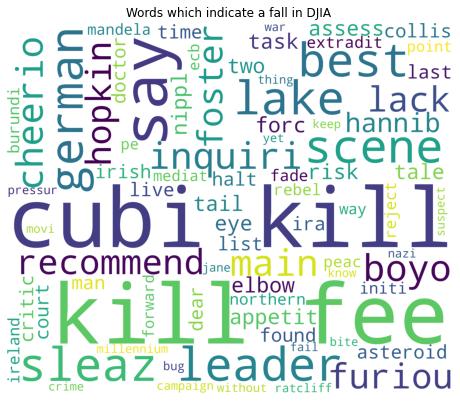

In [23]:
# Creating wordcloud for down_words
wordcloud1 = WordCloud(background_color='white', width=3000, height=2500).generate(down_words[1])
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title("Words which indicate a fall in DJIA ")
plt.show()

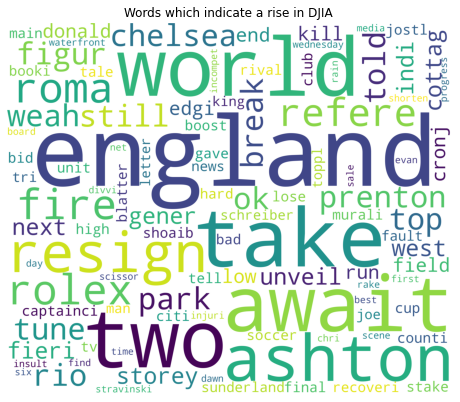

In [24]:
# Creating wordcloud for up_words
wordcloud2 = WordCloud(background_color='white', width=3000, height=2500).generate(up_words[5])
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title("Words which indicate a rise in DJIA ")
plt.show()

In [25]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=10000, ngram_range=(2, 2))

In [26]:
X_train = cv.fit_transform(train_corpus).toarray()
X_test = cv.transform(test_corpus).toarray()

4 - Build Model

4.1 - Logistic Regression

In [27]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

LogisticRegression()

In [28]:
lr_y_pred = lr_classifier.predict(X_test)

In [29]:
# Accuracy, Precision and Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score
score1 = accuracy_score(y_test, lr_y_pred)
score2 = precision_score(y_test, lr_y_pred)
score3 = recall_score(y_test, lr_y_pred)
print("---- Scores ----")
print("Accuracy score is: {}%".format(round(score1*100,2)))
print("Precision score is: {}".format(round(score2,2)))
print("Recall score is: {}".format(round(score3,2)))

---- Scores ----
Accuracy score is: 85.19%
Precision score is: 0.86
Recall score is: 0.85


In [30]:
lr_cm = confusion_matrix(y_test, lr_y_pred)
lr_cm

array([[159,  27],
       [ 29, 163]], dtype=int64)

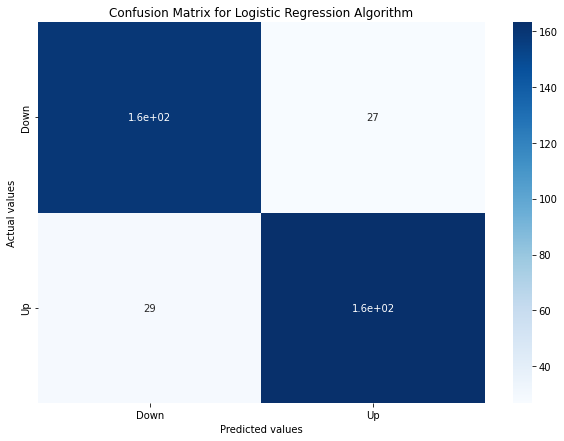

In [31]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(data=lr_cm, annot=True, cmap="Blues", xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Logistic Regression Algorithm')
plt.show()

4.2 - Random Forest Classifier

In [32]:
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [33]:
rf_y_pred = rf_classifier.predict(X_test)

In [34]:
# Accuracy, Precision and Recall
score1 = accuracy_score(y_test, rf_y_pred)
score2 = precision_score(y_test, rf_y_pred)
score3 = recall_score(y_test, rf_y_pred)
print("---- Scores ----")
print("Accuracy score is: {}%".format(round(score1*100,2)))
print("Precision score is: {}".format(round(score2,2)))
print("Recall score is: {}".format(round(score3,2)))

---- Scores ----
Accuracy score is: 83.33%
Precision score is: 0.82
Recall score is: 0.85


In [35]:
# Making the Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
rf_cm

array([[151,  35],
       [ 28, 164]], dtype=int64)

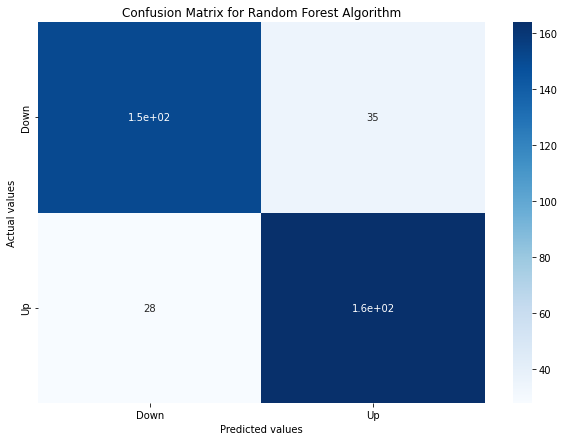

In [36]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(data=rf_cm, annot=True, cmap="Blues", xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Random Forest Algorithm')
plt.show()

4.3 - Multinomial Naive Bayes

In [37]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [38]:
# Predicting the Test set results
nb_y_pred = nb_classifier.predict(X_test)

In [39]:
# Accuracy, Precision and Recall
score1 = accuracy_score(y_test, nb_y_pred)
score2 = precision_score(y_test, nb_y_pred)
score3 = recall_score(y_test, nb_y_pred)
print("---- Scores ----")
print("Accuracy score is: {}%".format(round(score1*100,2)))
print("Precision score is: {}".format(round(score2,2)))
print("Recall score is: {}".format(round(score3,2)))

---- Scores ----
Accuracy score is: 83.07%
Precision score is: 0.84
Recall score is: 0.83


In [40]:
# Making the Confusion Matrix
nb_cm = confusion_matrix(y_test, nb_y_pred)
nb_cm

array([[155,  31],
       [ 33, 159]], dtype=int64)

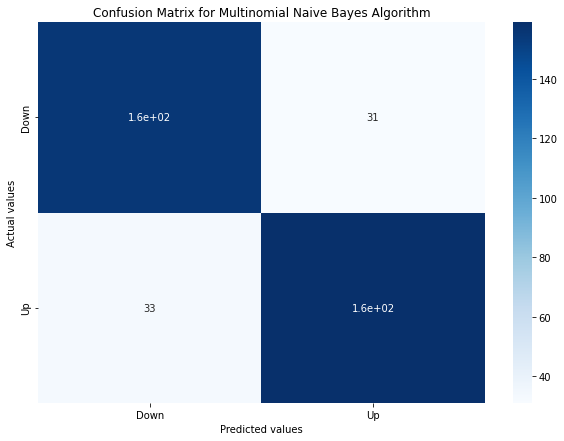

In [41]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(data=nb_cm, annot=True, cmap="Blues", xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Multinomial Naive Bayes Algorithm')
plt.show()

5 - Predictions

In [42]:
def stock_prediction(sample_news):
    sample_news = re.sub(pattern='[^a-zA-Z]',repl=' ', string=sample_news)
    sample_news = sample_news.lower()
    sample_news_words = sample_news.split()
    sample_news_words = [word for word in sample_news_words if not word in set(stopwords.words('english'))]
    ps = PorterStemmer()
    final_news = [ps.stem(word) for word in sample_news_words]
    final_news = ' '.join(final_news)
    temp = cv.transform([final_news]).toarray()
    return lr_classifier.predict(temp)

In [43]:
sample_test = df[df['Date'] > '20141231']
sample_test.reset_index(inplace=True)
sample_test = sample_test['Top1']

In [44]:
# Predicting values
row = randint(0, sample_test.shape[0]-1)
sample_news = sample_test[row]

print('News: {}'.format(sample_news))
if stock_prediction(sample_news):
    print('Prediction: The stock price will remain the same or will go down.')
else:
    print('Prediction: The stock price will go up!')

News: China shuts down stock market after 15 min 7% loss.
Prediction: The stock price will go up!


In [45]:
# Predicting values
row = randint(0,sample_test.shape[0]-1)
sample_news = sample_test[row]

print('News: {}'.format(sample_news))
if stock_prediction(sample_news):
    print('Prediction: The stock price will remain the same or will go down.')
else:
    print('Prediction: The stock price will go up!')

News: Brazil blogger known for reporting on corruption found decapitated
Prediction: The stock price will remain the same or will go down.


In [46]:
# Predicting values
row = randint(0,sample_test.shape[0]-1)
sample_news = sample_test[row]

print('News: {}'.format(sample_news))
if stock_prediction(sample_news):
    print('Prediction: The stock price will remain the same or will go down.')
else:
    print('Prediction: The stock price will go up!')

News: Fifa corruption: Qatar says investigations are racist, anti-Arab and show 'ugly face' of countries who lost 2022 World Cup bid
Prediction: The stock price will go up!


In [47]:
# Predicting values
row = randint(0, sample_test.shape[0]-1)
sample_news = sample_test[row]

print('News: {}'.format(sample_news))
if stock_prediction(sample_news):
    print('Prediction: The stock price will remain the same or will go down.')
else:
    print('Prediction: The stock price will go up!')

News: The White House on Monday sharply rebuked nearly four dozen Republican senators who sent a letter to Iranian leaders just as nuclear negotiations reach a pivotal moment, characterizing the correspondence as an illegitimate interference in President Obamas foreign policy.
Prediction: The stock price will go up!
